# Tải dữ liệu MS Marcro

In [1]:
!pip install datasets==2.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.4 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset = load_dataset('ms_marco', 'v1.1')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/10047 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/82326 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9650 [00:00<?, ? examples/s]

Dataset ms_marco downloaded and prepared to /root/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Danh sách câu truy vấn và tài liệu

In [3]:
subset = dataset['test']

In [4]:
queries_infos = []
queries = []
corpus = []

for sample in subset:
  query_type = sample['query_type']
  if query_type != 'entity':
    continue
  query_id = sample['query_id']
  query_str = sample['query']

  passages_dict = sample['passages']
  is_selected_lst = passages_dict['is_selected']
  passage_text_lst = passages_dict['passage_text']

  query_info = {
      'query_id': query_id,
      'query': query_str,
      'relevant_docs': []
  }

  current_len_corpus = len(corpus)
  for idx in range(len(is_selected_lst)):
    if is_selected_lst[idx] == 1:
      doc_idx = current_len_corpus + idx
      query_info['relevant_docs'].append(doc_idx)

  if query_info['relevant_docs'] == []:
    continue
  queries.append(query_str)
  queries_infos.append(query_info)
  corpus += passage_text_lst

# Chuẩn hoá văn bản

---



*   Chuyển chữ viết thường - Lowercasing
*   Xoá dấu câu - Punctuations removal
*   Xoá stopwords (Stopwords removal)
*   Stemming



In [5]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [6]:
nltk.download('stopwords')
english_stopwords = stopwords.words('english') # Khai bao danh sach stopword
remove_chars = string.punctuation # Danh sach char can xoa
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def tokenize(text):
  return text.split()

In [8]:
def text_normalize(text):
  text = text.lower()
  for char in remove_chars:
    text = text.replace(char, '')
  text = ' '.join([word for word in tokenize(text) if word not in english_stopwords])
  text = ' '.join([stemmer.stem(word) for word in tokenize(text)])
  return text

# Dictionary

In [9]:
def create_dictionary(corpus):
  dictionary = []
  for doc in corpus:
    normalized_doc = text_normalize(doc)
    tokens = tokenize(normalized_doc)
    for token in tokens:
      if token not in dictionary:
        dictionary.append(token)
  return dictionary

# Vectorization

In [10]:
def vectorize(text, dictionary):
  word_count_dict = {word: 0 for word in dictionary}
  tokens = tokenize(text)

  for token in tokens:
    try:
      word_count_dict[token] += 1
    except:
      pass
  vector = list(word_count_dict.values())
  return vector

# Ma trận document-term

In [17]:
def create_doc_term_matrix(corpus, dictionary):
  doc_term_matrix = {}
  for idx, doc in enumerate(corpus):
    normalized_doc = text_normalize(doc)
    vector = vectorize(normalized_doc, dictionary)
    doc_term_matrix[(doc, idx)] = vector
  return doc_term_matrix

# Tính tương đồng giữa 2 vector

In [13]:
from scipy import spatial
def similarity(a, b):
  return 1 - spatial.distance.cosine(a, b)

# Xây dựng hàm truy vấn

In [14]:
# 1. Vectorize query
# 2. Similarity
# 3. Ranking
def ranking(query, dictionary, doc_term_matrix):
  normalized_query = text_normalize(query)
  query_vec = vectorize(normalized_query, dictionary)
  scores = []
  for doc_info, doc_vec in doc_term_matrix.items():
    sim = similarity(query_vec, doc_vec)
    scores.append((sim, doc_info))
  scores.sort(reverse=True)

  return scores

# Thực hiện truy vấn bất kỳ

In [18]:
query_lst = ['what is the official language in Fiji']
top_k = 10
dictionary = create_dictionary(corpus)
doc_term_matrix = create_doc_term_matrix(corpus, dictionary)

for query in query_lst:
  scores = ranking(query, dictionary, doc_term_matrix)
  print(f'Query: {query}')
  print('--- Relevant docs ---')
  for idx in range(top_k):
    doc_score = scores[idx][0]
    doc_content = scores[idx][1][0]
    print(f'Top {idx + 1}; Score: {doc_score:.4f}')
    print(doc_content)
    print('\n')

Query: what is the official language in Fiji
--- Relevant docs ---
Top 1; Score: 0.6556
The official languages in Fiji are Fijian and English. A dialect of Hindustani is also widely spoken among Indo-Fijians.  _________________________________________   T … he official and everyday language of Fiji is English. Fijian and Fiji-Hindi are second languages in the island nation.


Top 2; Score: 0.6556
The official languages in Fiji are Fijian and English. A dialect of Hindustani is also widely spoken among Indo-Fijians.  _________________________________________   T … he official and everyday language of Fiji is English. Fijian and Fiji-Hindi are second languages in the island nation.


Top 3; Score: 0.5715
The official languages. Fiji’s 1997 Constitution established Fijian as one of the official languages of the country. Fijian is an Austronesian language, a grouping that includes thousands of other languages spanning the globe. The language is of the Malayo-Polynesian family, not too diff

# BERT Tokenizer

In [19]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [21]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
sample = 'where is Himalayas in the world map?'
encoding = tokenizer.encode(sample)
print(encoding)
print(tokenizer.convert_ids_to_tokens(encoding))

[101, 2073, 2003, 26779, 1999, 1996, 2088, 4949, 1029, 102]
['[CLS]', 'where', 'is', 'himalayas', 'in', 'the', 'world', 'map', '?', '[SEP]']


Semantic Search with pretrained BERT model
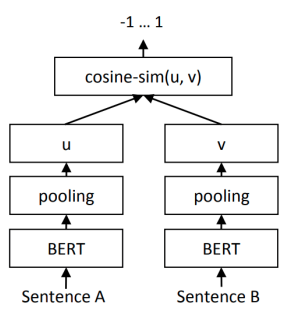